#  <font color='#FFE15D'><b>💎 Project 4: Speech Recognition 🔬</b></font>
<img src="http://dl.howsam.org/Deep-Catalyst/rocket-200px.png" alt="Deep Catalyst"/>

Deep Catalyst Course [webpage](https://howsam.org/downloads/deep-catalyst/)

by Howsam AI Academy (www.howsam.org)

# 🔴 **Environment Setup**

## 🟠  **Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 🟠 Perhaps you may need to install the `torchmetrics` library. To do so, you can execute this cell.

In [ ]:
!pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 11.2 MB/s eta 0:00:00


In [ ]:
!pip install -q torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.7 MB/s eta 0:00:00


# 🔴 **Import Libs**

In [ ]:
import csv
import os
import glob
from pathlib import Path
from typing import Tuple, Union
import torch
from torch import Tensor
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from torchaudio import datasets
from torchaudio import transforms as T
from torchaudio import models
import torchaudio.functional as AF
from torchaudio._internal import download_url_to_file
from torchaudio.datasets.utils import _extract_tar

from torcheval.metrics import WordErrorRate

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchmetrics.aggregation import MeanMetric
from tqdm import tqdm
import string
import random
import math

from IPython.display import Audio
from prettytable import PrettyTable

In [ ]:
!python --version

Python 3.10.12


In [ ]:
for lib in [np, pd, torch, torchaudio]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.23.5
pandas --> 1.5.3
torch --> 2.1.0+cu118
torchaudio --> 2.1.0+cu118


# 🔴 **Utils**

In [ ]:
def print_stats(waveform, sample_rate=None, src=None):
    if src:
        print("-" * 10)
        print("Source:", src)
        print("-" * 10)
    if sample_rate:
        print("Sample Rate:", sample_rate)
    print("Shape:", tuple(waveform.shape))
    print("Dtype:", waveform.dtype)
    print(f" - Max:     {waveform.max().item():6.3f}")
    print(f" - Min:     {waveform.min().item():6.3f}")
    print(f" - Mean:    {waveform.mean().item():6.3f}")
    print(f" - Std Dev: {waveform.std().item():6.3f}")
    print()
    print(waveform)
    print()

In [ ]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)

In [ ]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(T.AmplitudeToDB()(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [ ]:
def num_trainable_params(model):
    nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
    return nums

In [ ]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

In [ ]:
def char_to_index():
  char  = "-!'(),.:;?_ " + string.ascii_lowercase
  char_dict = {char: idx for idx, char in enumerate(char, 3)}
  char_dict['<OOV>'] = 0
  char_dict['<'] = 1 # SOS
  char_dict['>'] = 2 # EOS
  return char_dict

In [ ]:
def index_to_char():
  return {idx: char for char, idx in char_to_index().items()}

In [ ]:
def text_to_char(text):

    text = '<' + text + '>'

    text_lengths = len(text)
    text_indices = torch.LongTensor([char_to_index().get(char.lower(), char_to_index()['<OOV>']) for char in text])

    return text_lengths, text_indices

text_to_char('Project four: Speech Recognition!')

(35,
 tensor([ 1, 30, 32, 29, 24, 19, 17, 34, 14, 20, 29, 35, 32, 10, 14, 33, 30, 19,
         19, 17, 22, 14, 32, 19, 17, 29, 21, 28, 23, 34, 23, 29, 28,  4,  2]))

In [ ]:
def greedy_decode(predictions):
    # predictions: Tensor of shape (seq_len, batch_size, num_classes)
    _, max_probs = torch.max(predictions, dim=-1)
    return max_probs

def idx_to_text(indices, idx_to_char):
    # Convert indices to characters using a mapping
    return ''.join([idx_to_char()[idx.item()] for idx in indices])

def decode_predictions(predictions, idx_to_char):
    # Apply greedy decoding
    decoded_indices = greedy_decode(predictions)

    # Convert indices to text
    decoded_texts = [idx_to_text(indices, idx_to_char()) for indices in decoded_indices]
    return decoded_texts

# 🔴 **Arguments**

In [ ]:
seed = 42
device = 'cuda' if torch.cuda.is_available() else 'cpu'
root_dir = 'content/data/data'
batch_size = 4
num_classes = 40
sample_rate = 22050
new_freq = 16000
n_fft = 400
hop_length = 160
n_mels = 64
freq_mask_param = 15
time_mask_param = 35
in_channels = 1
dropout = 0.1
vocab_size = 40
d_model = 200
num_channels = 64
nhead = 2
dim_feedforward = 400
num_encoder_layers = 4
num_decoder_layers = 1

# 🔴 **Dataset**

## 🟠 Load the Dataset

Load the LJ Speech dataset.

Check the structure of the data, such as the waveform samples, corresponding






In [ ]:
dataset = datasets.LJSPEECH(root=root_dir,
                            url='https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2',
                            download=True)

In [ ]:
print(f'Number of short audio clips: {len(dataset)}')

Number of short audio clips: 13100


In [ ]:
dataset[1803]

(tensor([[-0.0013, -0.0008, -0.0005,  ..., -0.0007, -0.0009, -0.0010]]),
 22050,
 'As the law stood since the passing of the 9th George IV. c. 40, any two justices might remove a prisoner found to be insane, either on commitment',
 'As the law stood since the passing of the ninth George the fourth c. forty, any two justices might remove a prisoner found to be insane, either on commitment')

### 🟡 **Load Audio** 🎵

In [ ]:
waveform, sample_rate, transcript, normalized_transcript = dataset[15]
print('waveform:\n', waveform)
print('waveform shape:\n', waveform.shape)
print('sample_rate:\n', sample_rate)
print('normalized_transcript:\n', normalized_transcript)

waveform:
 tensor([[-0.0011, -0.0011, -0.0011,  ...,  0.0004,  0.0003,  0.0002]])
waveform shape:
 torch.Size([1, 116125])
sample_rate:
 22050
normalized_transcript:
 The Middle Ages brought calligraphy to perfection, and it was natural therefore


In [ ]:
Audio(waveform.numpy(), rate=sample_rate)

Sample Rate: 22050
Shape: (1, 116125)
Dtype: torch.float32
 - Max:      0.737
 - Min:     -0.607
 - Mean:     0.000
 - Std Dev:  0.100

tensor([[-0.0011, -0.0011, -0.0011,  ...,  0.0004,  0.0003,  0.0002]])



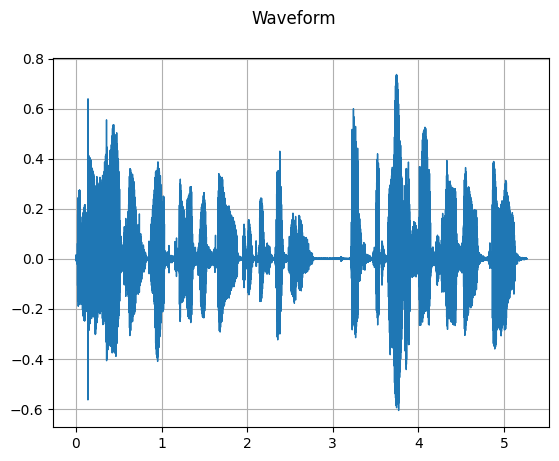

In [ ]:
print_stats(waveform, sample_rate)
plot_waveform(waveform, sample_rate)

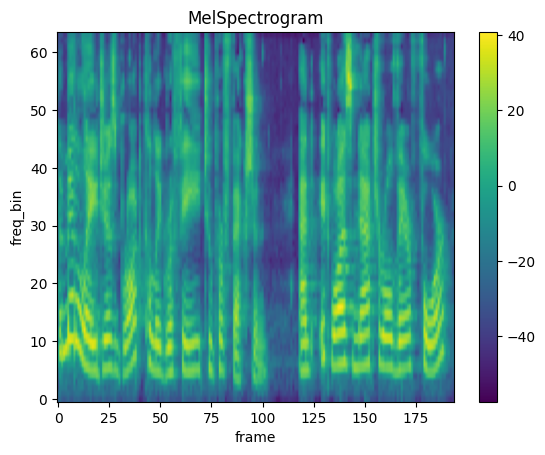

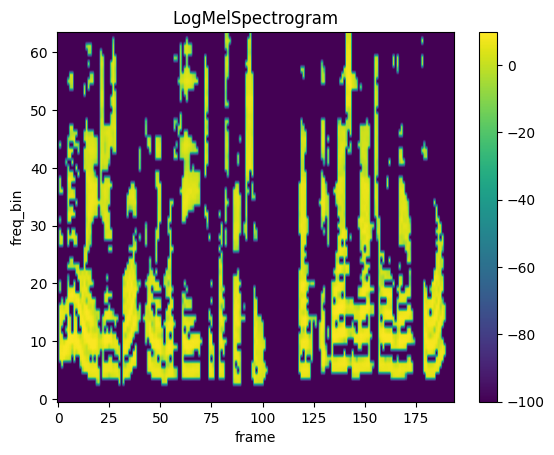

In [ ]:
mel_spectrogram = T.MelSpectrogram(sample_rate=sample_rate,
                                   n_fft=n_fft,
                                   hop_length=hop_length,
                                   n_mels=n_mels)
melspec = mel_spectrogram(waveform)
log_mel_spec = torch.log(mel_spectrogram(waveform))

plot_spectrogram(melspec[0], title='MelSpectrogram')
plot_spectrogram(log_mel_spec[0], title='LogMelSpectrogram')

## 🟠 Dataset Preparation

Use Source code of [torchaudio.datasets.ljspeech](https://pytorch.org/audio/stable/_modules/torchaudio/datasets/ljspeech.html#LJSPEECH) and Split the dataset to training, validation, and testing sets based on provided text files in data folder.

In [ ]:
_RELEASE_CONFIGS = {
    "release1": {
        "folder_in_archive": "wavs",
        "url": "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2",
        "checksum": "be1a30453f28eb8dd26af4101ae40cbf2c50413b1bb21936cbcdc6fae3de8aa5",
    }
}

class LJSPEECH(Dataset):
    """*LJSpeech-1.1* :cite:`ljspeech17` dataset.

    Args:
        root (str or Path): Path to the directory where the dataset is found or downloaded.
        url (str, optional): The URL to download the dataset from.
            (default: ``"https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"``)
        folder_in_archive (str, optional):
            The top-level directory of the dataset. (default: ``"wavs"``)
        download (bool, optional):
            Whether to download the dataset if it is not found at root path. (default: ``False``).
    """

    def __init__(
        self,
        root: Union[str, Path],
        url: str = _RELEASE_CONFIGS["release1"]["url"],
        folder_in_archive: str = _RELEASE_CONFIGS["release1"]["folder_in_archive"],
        split_file: str = None,
        download: bool = False

    ) -> None:

        self._parse_filesystem(root, url, folder_in_archive, split_file, download)

    def _parse_filesystem(self, root: str, url: str, folder_in_archive: str, split_file: str, download: bool) -> None:
        root = Path(root)

        basename = os.path.basename(url)
        archive = root / basename

        basename = Path(basename.split(".tar.bz2")[0])
        folder_in_archive = basename / folder_in_archive

        self._path = root / folder_in_archive
        self._metadata_path = root / basename / "metadata.csv"

        if download:
            if not os.path.isdir(self._path):
                if not os.path.isfile(archive):
                    checksum = _RELEASE_CONFIGS["release1"]["checksum"]
                    download_url_to_file(url, archive, hash_prefix=checksum)
                _extract_tar(archive)
        else:
            if not os.path.exists(self._path):
                raise RuntimeError(
                    f"The path {self._path} doesn't exist. "
                    "Please check the ``root`` path or set `download=True` to download it"
                )

        # read {train, valid, test} files
        with open(split_file) as f:
            self.split_samples = f.read().strip().split("\n")

        with open(self._metadata_path, "r", newline="") as metadata:
            flist = csv.reader(metadata, delimiter="|", quoting=csv.QUOTE_NONE)
            self._flist = list(flist)
            self._flist = [item for sample in self.split_samples for item in self._flist if item[0] == sample]


    def __getitem__(self, n: int) -> Tuple[torch.Tensor, int, str, str]:
        """Load the n-th sample from the dataset.

        Args:
            n (int): The index of the sample to be loaded

        Returns:
            Tuple of the following items;

            Tensor:
                Waveform
            int:
                Sample rate
            str:
                Transcript
            str:
                Normalized Transcript
        """
        line = self._flist[n]
        fileid, transcript, normalized_transcript = line
        fileid_audio = self._path / (fileid + ".wav")

        # load audio
        waveform, sample_rate = torchaudio.load(fileid_audio)

        return (
            waveform,
            sample_rate,
            transcript,
            normalized_transcript,
        )

    def __len__(self) -> int:
        return len(self._flist)

In [ ]:
train_set = LJSPEECH(root=root_dir, split_file='./data/train.txt')
valid_set = LJSPEECH(root=root_dir, split_file='./data/valid.txt')
test_set = LJSPEECH(root=root_dir, split_file='./data/test.txt')

In [ ]:
len(train_set), len(valid_set), len(test_set)

(12500, 100, 500)

In [ ]:
train_set[5000]

(tensor([[0.0004, 0.0004, 0.0002,  ..., 0.0009, 0.0013, 0.0000]]),
 22050,
 'It is suggested that an organization shorn of its power to investigate all the possibilities of danger to the President',
 'It is suggested that an organization shorn of its power to investigate all the possibilities of danger to the President')

## 🟠 EDA

Total Clips	13,100

Total Words	225,715

Total Characters	1,308,678

Total Duration	23:55:17

Mean Clip Duration	6.57 sec

Min Clip Duration	1.11 sec

Max Clip Duration	10.10 sec

Mean Words per Clip	17.23

Distinct Words	13,821

In [ ]:
file_path = os.path.join(root_dir, "LJSpeech-1.1/", "metadata.csv")

df_metadata = pd.read_csv(file_path, sep='|', header=None)
df_metadata.columns = ['waveform_id', 'transcript', 'normalized_transcript']
df_metadata

,waveform_id,transcript,normalized_transcript
0,LJ001-0001,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed...","produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...
...,...,...,...
13095,LJ050-0274,made certain recommendations which it believes...,made certain recommendations which it believes...
13096,LJ050-0275,materially improve upon the procedures in effe...,materially improve upon the procedures in effe...
13097,LJ050-0276,"As has been pointed out, the Commission has no...","As has been pointed out, the Commission has no..."
13098,LJ050-0277,with the active cooperation of the responsible...,with the active cooperation of the responsible...


In [ ]:
df_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13100 entries, 0 to 13099
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   waveform_id            13100 non-null  object
 1   transcript             13100 non-null  object
 2   normalized_transcript  13084 non-null  object
dtypes: object(3)
memory usage: 307.2+ KB


In [ ]:
# basic statistics
num_samples = len(df_metadata)
print(f"Total Clips: {num_samples}")

Total Clips: 13100


In [ ]:
# text analysis
text_lengths = [len(entry) for entry in df_metadata['transcript']]
print(f"Average text length: {sum(text_lengths) / num_samples:.2f}")
print(f"Max text length: {max(text_lengths)}")
print(f"Min text length: {min(text_lengths)}")
print()

total_words = 0
for entry in df_metadata['transcript']:
    words = entry.split()
    total_words += len(words)

print(f"Total words: {total_words}")

Average text length: 98.47
Max text length: 331
Min text length: 5

Total words: 221382


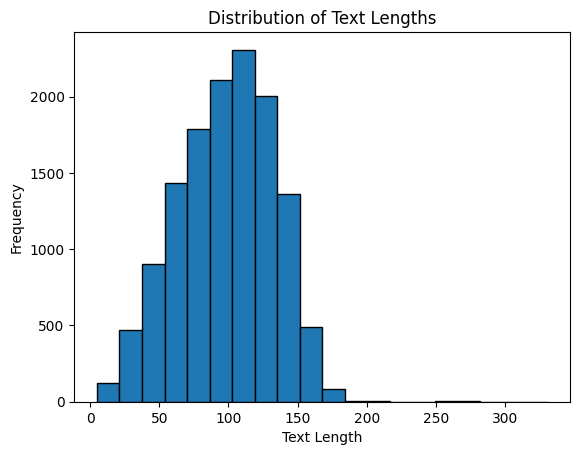

In [ ]:
# text length distribution
plt.hist(text_lengths, bins=20, edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# calculate duration time of 1000 random Clip
wavs_path = os.path.join(root_dir, "LJSpeech-1.1/wavs/*.wav")
paths = glob.glob(wavs_path)
num_random_clip = 1000
random_path = random.sample(paths, num_random_clip)

durations = []
for path in random_path:
    waveform, sampling_rate = torchaudio.load(path)
    duration = waveform.size(1) / sample_rate
    durations.append(duration)

durations_sum = sum(durations)
durations_avg = durations_sum / len(durations)
durations_min = min(durations)
durations_max = max(durations)

print(f"durations_sum: {durations_sum:.2f} sec.")
print(f"durations_avg: {durations_avg:.2f}  sec.")
print(f"durations_min: {durations_min:.2f}  sec.")
print(f"durations_max: {durations_max:.2f}  sec.")

durations_sum: 6470.34 sec.
durations_avg: 6.47  sec.
durations_min: 1.13  sec.
durations_max: 10.10  sec.


## 🟠 Data Processing

In [ ]:
train_audio_transforms = nn.Sequential(T.MelSpectrogram(sample_rate=sample_rate,
                                                        n_fft=n_fft,
                                                        hop_length=hop_length,
                                                        n_mels=n_mels),
                                        T.FrequencyMasking(freq_mask_param=freq_mask_param),
                                        T.TimeMasking(time_mask_param=time_mask_param))

valid_audio_transforms = T.MelSpectrogram(sample_rate=sample_rate,
                                          n_fft=n_fft,
                                          hop_length=hop_length,
                                          n_mels=n_mels)

In [ ]:
def data_processing(data, phase='train'):
    mel_spectrograms = []
    texts = []
    input_lengths = []
    texts_lengths = []

    for (waveform, _, _, normalized_transcript) in data:
        if phase == 'train':
            mel_spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        else:
            mel_spec = valid_audio_transforms(waveform).squeeze(0).transpose(0, 1)

        mel_spectrograms.append(mel_spec)
        text_lens, text_indices = text_to_char(normalized_transcript)
        texts.append(torch.LongTensor(text_indices))
        input_lengths.append(mel_spec.shape[0])
        texts_lengths.append(text_lens)

    mel_spectrograms = pad_sequence(mel_spectrograms, batch_first=True)
    texts = pad_sequence(texts, batch_first=True)

    return mel_spectrograms, texts, torch.IntTensor(input_lengths), torch.LongTensor(texts_lengths)

## 🟠 Dataloader

In [ ]:
train_loader = DataLoader(train_set,
                         batch_size,
                         shuffle=True,
                         collate_fn=lambda data: data_processing(data, 'train'))

train_loader = DataLoader(valid_set,
                         batch_size,
                         shuffle=False,
                         collate_fn=lambda data: data_processing(data, 'valid'))

train_loader = DataLoader(test_set,
                         batch_size,
                         shuffle=False,
                         collate_fn=lambda data: data_processing(data, 'test'))

In [ ]:
mel_spectrograms, texts, input_lengths, text_lengths = next(iter(train_loader))
mel_spectrograms.shape, texts.shape, input_lengths, text_lengths

(torch.Size([4, 1301, 64]),
 torch.Size([4, 151]),
 tensor([ 361, 1301, 1181, 1147], dtype=torch.int32),
 tensor([ 44, 151, 141, 128]))

# 🔴 **Model**

[DeepSpeech2Extractor](https://github.com/sooftware/deepspeech2/blob/main/deepspeech2/convolution.py) is used for feature embedding.



In [ ]:
# MIT License
#
# Copyright (c) 2021 Soohwan Kim.
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

class MaskCNN(nn.Module):
    """
    Masking Convolutional Neural Network
    Adds padding to the output of the module based on the given lengths.
    This is to ensure that the results of the model do not change when batch sizes change during inference.
    Input needs to be in the shape of (batch_size, channel, hidden_dim, seq_len)
    Refer to https://github.com/SeanNaren/deepspeech.pytorch/blob/master/model.py
    Copyright (c) 2017 Sean Naren
    MIT License
    Args:
        sequential (torch.nn): sequential list of convolution layer
    Inputs: inputs, seq_lengths
        - **inputs** (torch.FloatTensor): The input of size BxCxHxT
        - **seq_lengths** (torch.IntTensor): The actual length of each sequence in the batch
    Returns: output, seq_lengths
        - **output**: Masked output from the sequential
        - **seq_lengths**: Sequence length of output from the sequential
    """
    def __init__(self, sequential: nn.Sequential) -> None:
        super(MaskCNN, self).__init__()
        self.sequential = sequential

    def forward(self, inputs: Tensor, seq_lengths: Tensor) -> Tuple[Tensor, Tensor]:
        output = None

        for module in self.sequential:
            output = module(inputs)
            mask = torch.BoolTensor(output.size()).fill_(0)

            if output.is_cuda:
                mask = mask.cuda()

            seq_lengths = self._get_sequence_lengths(module, seq_lengths)

            for idx, length in enumerate(seq_lengths):
                length = length.item()

                if (mask[idx].size(2) - length) > 0:
                    mask[idx].narrow(dim=2, start=length, length=mask[idx].size(2) - length).fill_(1)

            output = output.masked_fill(mask, 0)
            inputs = output

        return output, seq_lengths

    def _get_sequence_lengths(self, module: nn.Module, seq_lengths: Tensor) -> Tensor:
        """
        Calculate convolutional neural network receptive formula
        Args:
            module (torch.nn.Module): module of CNN
            seq_lengths (torch.IntTensor): The actual length of each sequence in the batch
        Returns: seq_lengths
            - **seq_lengths**: Sequence length of output from the module
        """
        if isinstance(module, nn.Conv2d):
            numerator = seq_lengths + 2 * module.padding[1] - module.dilation[1] * (module.kernel_size[1] - 1) - 1
            seq_lengths = numerator.float() / float(module.stride[1])
            seq_lengths = seq_lengths.int() + 1

        elif isinstance(module, nn.MaxPool2d):
            seq_lengths >>= 1

        return seq_lengths.int()


class DeepSpeech2Extractor(nn.Module):
    """
    DeepSpeech2 extractor for automatic speech recognition described in
    "Deep Speech 2: End-to-End Speech Recognition in English and Mandarin" paper
    - https://arxiv.org/abs/1512.02595
    Args:
        input_dim (int): Dimension of input vector
        in_channels (int): Number of channels in the input vector
        out_channels (int): Number of channels produced by the convolution
        activation (str): Activation function
    Inputs: inputs, input_lengths
        - **inputs** (batch, time, dim): Tensor containing input vectors
        - **input_lengths**: Tensor containing containing sequence lengths
    Returns: outputs, output_lengths
        - **outputs**: Tensor produced by the convolution
        - **output_lengths**: Tensor containing sequence lengths produced by the convolution
    """
    def __init__(
            self,
            input_dim: int,
            in_channels: int = 1,
            out_channels: int = 32,
            activation: str = 'hardtanh',
    ) -> None:
        super(DeepSpeech2Extractor, self).__init__()
        self.input_dim = input_dim
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.activation = activation
        self.conv = MaskCNN(
            nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=(41, 11), stride=(2, 2), padding=(20, 5), bias=False),
                nn.BatchNorm2d(out_channels),
                self.activation,
                nn.Conv2d(out_channels, out_channels, kernel_size=(21, 11), stride=(2, 1), padding=(10, 5), bias=False),
                nn.BatchNorm2d(out_channels),
                self.activation,
            )
        )

    def forward(self, inputs: Tensor, input_lengths: Tensor) -> Tuple[Tensor, Tensor]:
        """
        inputs: torch.FloatTensor (batch, time, dimension)
        input_lengths: torch.IntTensor (batch)
        """
        outputs, output_lengths = self.conv(inputs.unsqueeze(1).transpose(2, 3), input_lengths)

        batch_size, channels, dimension, seq_lengths = outputs.size()
        outputs = outputs.permute(0, 3, 1, 2)
        outputs = outputs.view(batch_size, seq_lengths, channels * dimension)

        return outputs, output_lengths

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, dropout: float = 0.1, batch_first: bool = False, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        self.batch_first = batch_first
        den = torch.exp(-torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)

        if self.batch_first:
            pos_embedding = pos_embedding.unsqueeze(0)
        else:
            pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        if self.batch_first:
            return self.dropout(token_embedding + self.pos_embedding[:, :token_embedding.size(1), :])
        else:
            return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :, :])

In [ ]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size, padding_idx: int = 0):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

In [ ]:
class SpeechRecognitionModel(nn.Module):
      def __init__(self, input_dim, hidden_dim, num_classes, nhead, dim_feedforward,
                   num_encoder_layers, num_decoder_layers, dropout=0.1, batch_first=True,
                   activation=nn.Hardtanh()):
          super().__init__()

          # Convolutional feature extraction
          self.feature_embedding = DeepSpeech2Extractor(input_dim, activation=activation)

          # Linear Projection
          self.linear_proj = nn.LazyLinear(hidden_dim)

          # Transformer encoder layers
          self.transformer_layer_enc = nn.TransformerEncoderLayer(d_model=hidden_dim,
                                                                  nhead=nhead,
                                                                  dim_feedforward=dim_feedforward,
                                                                  batch_first=batch_first)
          # Transformer encoder
          self.transformer_encoder = nn.TransformerEncoder(encoder_layer=self.transformer_layer_enc,
                                               num_layers=num_encoder_layers)

          # Output embedding
          self.output_embed = TokenEmbedding(num_classes, hidden_dim)

          # Positional encoding for decoder
          self.positional_encoding_decoder = PositionalEncoding(emb_size=hidden_dim,
                                                                dropout=dropout,
                                                                batch_first=batch_first)

          # Transformer decoder layers
          self.transformer_layer_dec = nn.TransformerDecoderLayer(d_model=hidden_dim,
                                                                  nhead=nhead,
                                                                  dim_feedforward=dim_feedforward,
                                                                  batch_first=batch_first)
          # Transformer decoder
          self.transformer_decoder = nn.TransformerDecoder(decoder_layer=self.transformer_layer_dec,
                                               num_layers=num_decoder_layers)

          # Fully connected layer for classification
          self.fc = nn.LazyLinear(num_classes)

      def generate_subsequent_mask(self, seq_len):
          mask = (torch.triu(torch.ones(seq_len, seq_len)) == 1).transpose(0, 1)
          mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
          return mask


      def forward(self, mel_spectrograms, texts, input_lengths, texts_lengths):
          features, features_lengths = self.feature_embedding(mel_spectrograms, input_lengths)
          features = self.linear_proj(features)
          encoder_outputs = self.transformer_encoder(features)
          texts_mask = self.generate_subsequent_mask(texts.size(1))
          texts = self.output_embed(texts)
          texts = self.positional_encoding_decoder(texts)
          decoder_outputs = self.transformer_decoder(texts, encoder_outputs, texts_mask)
          outputs = self.fc(decoder_outputs)
          return outputs, features_lengths

In [ ]:
model = SpeechRecognitionModel(n_mels, d_model, num_classes, nhead, d_model * 4,
                               num_encoder_layers, num_decoder_layers, batch_first=True)

In [ ]:
model

SpeechRecognitionModel(
  (feature_embedding): DeepSpeech2Extractor(
    (activation): Hardtanh(min_val=-1.0, max_val=1.0)
    (conv): MaskCNN(
      (sequential): Sequential(
        (0): Conv2d(1, 32, kernel_size=(41, 11), stride=(2, 2), padding=(20, 5), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=-1.0, max_val=1.0)
        (3): Conv2d(32, 32, kernel_size=(21, 11), stride=(2, 1), padding=(10, 5), bias=False)
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): Hardtanh(min_val=-1.0, max_val=1.0)
      )
    )
  )
  (linear_proj): LazyLinear(in_features=0, out_features=200, bias=True)
  (transformer_layer_enc): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=200, out_features=200, bias=True)
    )
    (linear1): Linear(in_features=200, out_features=800, bias=True)
    

In [ ]:
outs, inputs_len = model(mel_spectrograms, texts, input_lengths, text_lengths)
outs.shape, inputs_len

(torch.Size([4, 151, 40]), tensor([181, 651, 591, 574], dtype=torch.int32))

In [ ]:
print("Number of trainable parameters of model:")
print(f"Total Model: {num_trainable_params(model)}")
print(f"* FeatureEmbedding: {num_trainable_params(model.feature_embedding)}")
print(f"* LinearProjection: {num_trainable_params(model.linear_proj)}")
print(f"* TransformerLayerEncoder: {num_trainable_params(model.transformer_layer_enc)}")
print(f"* TransformerEncoder: {num_trainable_params(model.transformer_encoder)}")
print(f"* OutputEmbedding: {num_trainable_params(model.output_embed)}")
print(f"* TransformerLayerDecoder: {num_trainable_params(model.transformer_layer_dec)}")
print(f"* TransformerDecoder: {num_trainable_params(model.transformer_decoder)}")
print(f"* FC: {num_trainable_params(model.fc)}")

Number of trainable parameters of model:
Total Model: 4.070344
* FeatureEmbedding: 0.251104
* LinearProjection: 0.1026
* TransformerLayerEncoder: 0.4826
* TransformerEncoder: 1.9304
* OutputEmbedding: 0.008
* TransformerLayerDecoder: 0.6438
* TransformerDecoder: 0.6438
* FC: 0.00804


# 🔴 **Config**

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
loss_fn = nn.CTCLoss(blank=0, zero_infinity=True)
metric = WordErrorRate()

# 🔴 **Train ➰**

# 🔴 **Evaluation**

# 🔴 **Training Process 〽️**

# 🔴 **Test**